In [1]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import BatchNorm2d

# from torch.nn import LogSoftmax
from torch import flatten

In [2]:
class LeNet(Module):
    def __init__(self):
        # call the parent constructor
        super(LeNet, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels = 2, out_channels = 4,\
                            kernel_size = (2, 6), stride = (2,2))#2 - height, 6 - width 
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(3, 3), stride=(3, 3)) #stride = step
        
        
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=4, out_channels=8,\
                            kernel_size=(4, 4))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        
        
        # initialize third set of CONV => RELU => POOL layers
        self.conv3 = Conv2d(in_channels=8, out_channels=16,\
                            kernel_size=(3, 3))
        self.relu3 = ReLU()
        self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        
        
        
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=32, out_features=8)
        self.relu4 = ReLU()
        # initialize our softmax classifier
        self.fc2 = Linear(in_features=8, out_features=1)
#         self.logSoftmax = LogSoftmax(dim=1)
    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
#         print(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)


        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers

        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu4(x)

        # pass the output to our softmax classifier to get our output
        # predictions
        output = self.fc2(x)
    #     output = self.logSoftmax(x)
        # return the output predictions
        return output

In [3]:
class LeNet(Module):
    def __init__(self):
        # call the parent constructor
        super(LeNet, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels = 2, out_channels = 4,\
                            kernel_size = (4, 10), stride = (4,5))#2 - height, 6 - width 
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(4, 3), stride=(4, 3)) #stride = step
        
        
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=48, out_features=8)
        self.relu2 = ReLU()
        self.fc2 = Linear(in_features=8, out_features=3)
        self.relu3 = ReLU()
        # initialize our softmax classifier
        self.fc3 = Linear(in_features=3, out_features=1)
#         self.logSoftmax = LogSoftmax(dim=1)
    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
#         print(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = flatten(x, 1)
        
        
        
        x = self.fc1(x)
        x = self.relu2(x)

        x = self.fc2(x)
        x = self.relu3(x)

        output = self.fc3(x)
    #     output = self.logSoftmax(x)
        # return the output predictions
        return output

In [4]:
class LeNet(Module):
    def __init__(self):
        # call the parent constructor
        super(LeNet, self).__init__()

        self.norm1 = BatchNorm2d(2)

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels = 2, out_channels = 8,\
                            kernel_size = (16, 20), stride = (16,10))#16 - height, 20 - width 
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #stride = step
        
#         self.norm2 = BatchNorm2d(8)
        
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=32, out_features=8)
        self.relu2 = ReLU()
        self.fc2 = Linear(in_features=8, out_features=1)

    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
#         print(x)
        x = self.norm1(x)
    
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = flatten(x, 1)
        
        
        
        x = self.fc1(x)
        x = self.relu2(x)

        output = self.fc2(x)

        return output

In [5]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# from sklearn.metrics import classification_report

import glob
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import matplotlib.pyplot as plt
import argparse
import torch
import time

In [6]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []

        target_954 = np.load('data_segment/Y_natur_954.npz')
        for j in range(3000):
            self.data.append(["data_segment/natur_X/954_" + str(j) + '.npz',target_954['arr_0'][j]])
#         print(self.data)

        target_9_7 = np.load('data_segment/Y_natur_9_7.npz')
#         print(target_9_7['arr_0'])
        for j in range(3000):
            self.data.append(["data_segment/natur_X/9_7_" + str(j) + '.npz',target_9_7['arr_0'][j]])

        
        target_Air = np.load('data_segment/Y_natur_Air.npz')
#         print(target_Air['arr_0'])
        for j in range(3000):
            self.data.append(["data_segment/natur_X/Air_" + str(j) + '.npz',target_Air['arr_0'][j]])
        
        temp = np.load('data_segment/natur_X/954_0.npz')
        self.img_dim = temp['arr_0'].shape  
        print(self.img_dim)
        
        
    def __len__(self):
        return len(self.data)    
    
    
    def __getitem__(self, idx):
        img_path, target = self.data[idx]
        
        img = np.load(img_path)
        img_tensor = torch.from_numpy(img['arr_0'])
        
        target_tensor = torch.tensor(target)
#         print(target_tensor, target)
        
#         img_tensor = img_tensor.permute(2, 0, 1)
#         class_id = torch.tensor([class_id])
        
        return img_tensor, target_tensor

In [8]:
data = CustomDataset()

print(len(data))

(2, 64, 50)
9000


In [9]:
print(data[1][0].size())
print(data[1][0].type())
print(data[1][1].type())
print(data[1][1], data[1][1].item())
# print(data[1][0])


torch.Size([2, 64, 50])
torch.DoubleTensor
torch.DoubleTensor
tensor(0.0319, dtype=torch.float64) 0.03186977247219236


In [10]:
Train_split = 0.7
Val_split = 0.15
Test_split = 0.15

(trainData, valData, testData) = random_split(data, [Train_split, Val_split, Test_split],\
                                              generator=torch.Generator().manual_seed(42))

In [11]:
print(len(trainData))
print(len(valData))
print(len(testData))

6300
1350
1350


In [33]:
BATCH_SIZE = 32
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)



# print(testDataLoader.dataset[0])

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
print(trainSteps)

valSteps = len(valDataLoader.dataset) // BATCH_SIZE
print(valSteps)

testSteps = len(testDataLoader.dataset) // BATCH_SIZE
print(testSteps)


# print(trainDataLoader.dataset)
# print(trainDataLoader.dataset[1])
# print(trainDataLoader.dataset[1][0].type())
# print(trainDataLoader.dataset[1][1])

196
42
42


In [34]:
# define training hyperparameters
INIT_LR = 0.001

# initialize the LeNet model
print("[INFO] initializing the LeNet model...")

model = LeNet().to(device)
model.type(torch.cuda.DoubleTensor)
# model.type(torch.DoubleTensor)


print(model)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)

scheduler = ReduceLROnPlateau(opt, 'min')



lossMSE = nn.MSELoss()
# lossMAE = nn.L1Loss()

# initialize a dictionary to store training history
H = {"train_loss": [],"val_loss": []}


[INFO] initializing the LeNet model...
LeNet(
  (norm1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(2, 8, kernel_size=(16, 20), stride=(16, 10))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [35]:
EPOCHS = 100
print("[INFO] training the network...")


startTime = time.time()
# loop over our epochs
for e in range(0, EPOCHS):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
   
    # loop over the training set
    for id_batch, (x, y) in enumerate(trainDataLoader):
#         print(id_batch)
#         print(y)
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
#         print(y.size(), y.type())
#         print(x.size(), x.type())
#         print(x)
        # perform a forward pass and calculate the training loss
        pred = model(x)
#         print(pred)
        y = torch.reshape(y,(len(y),1))

        loss = lossMSE(pred, y)
#         loss = lossMAE(pred, y)
        
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        totalTrainLoss += loss
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in valDataLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = model(x)
            y = torch.reshape(y,(len(y),1))
            totalValLoss += lossMSE(pred, y)
#             totalValLoss += lossMAE(pred, y)
    
    scheduler.step(totalValLoss)
    
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Val loss: {:.6f}".format(
        torch.sqrt(avgTrainLoss), torch.sqrt(avgValLoss)))
# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: \
        {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/100
Train loss: 0.045707, Val loss: 0.010928
[INFO] EPOCH: 2/100
Train loss: 0.010927, Val loss: 0.008390
[INFO] EPOCH: 3/100
Train loss: 0.013507, Val loss: 0.016788
[INFO] EPOCH: 4/100
Train loss: 0.011797, Val loss: 0.005481
[INFO] EPOCH: 5/100
Train loss: 0.007365, Val loss: 0.007082
[INFO] EPOCH: 6/100
Train loss: 0.008063, Val loss: 0.005725
[INFO] EPOCH: 7/100
Train loss: 0.009588, Val loss: 0.012265
[INFO] EPOCH: 8/100
Train loss: 0.006954, Val loss: 0.005419
[INFO] EPOCH: 9/100
Train loss: 0.006514, Val loss: 0.008794
[INFO] EPOCH: 10/100
Train loss: 0.006107, Val loss: 0.007497
[INFO] EPOCH: 11/100
Train loss: 0.006158, Val loss: 0.009796
[INFO] EPOCH: 12/100
Train loss: 0.006482, Val loss: 0.003493
[INFO] EPOCH: 13/100
Train loss: 0.004238, Val loss: 0.004127
[INFO] EPOCH: 14/100
Train loss: 0.004212, Val loss: 0.004438
[INFO] EPOCH: 15/100
Train loss: 0.004254, Val loss: 0.004535
[INFO] EPOCH: 16/100
Train loss: 0.004094, Val l

In [36]:
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()

    # initialize a list to store our predictions
    preds = []
    # loop over the test set
    for (x, y) in testDataLoader:
        # send the input to the device
        x = x.to(device)
        # make the predictions and add them to the list
        pred = model(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())


[INFO] evaluating network...


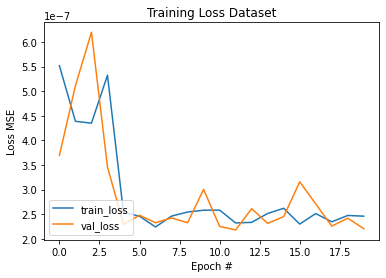

In [37]:
# plot the training loss and accuracy
# plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"][80:], label="train_loss")
plt.plot(H["val_loss"][80:], label="val_loss")


plt.title("Training Loss Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss MSE")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])
# serialize the model to disk
# torch.save(model, args["model"])

/tmp/ipykernel_3880/1781487853.py:24: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(y.numpy()), np.log((pred.flatten().cpu()).numpy()), color = 'black')


0.0002711500274017453


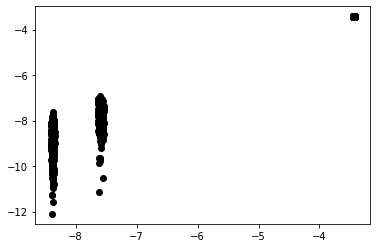

In [23]:
from torchmetrics import MeanSquaredError
mean_squared_error = MeanSquaredError()
        
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()

    # initialize a list to store our predictions
    preds = []
    loss = 0
    # loop over the test set
    for (x, y) in testDataLoader:
        # send the input to the device
        x = x.to(device)
        # make the predictions and add them to the list
        pred = model(x).cpu().flatten()
#         print(y)
#         print(pred)
        loss += mean_squared_error(pred, y)        
        
        
#         print(y-pred)
#         print(y.numpy(), (pred.flatten().cpu()).numpy())
        plt.scatter(np.log(y.numpy()), np.log((pred.flatten().cpu()).numpy()), color = 'black')
#         preds.extend(pred.argmax(axis=1).cpu().numpy())
print(torch.sqrt(loss/testSteps).item())       

        
        

In [ ]:
# m = nn.BatchNorm1d(100)
# Without Learnable Parameters
m = nn.BatchNorm1d(100, affine=False)

input = 100*torch.randn(20, 100)

print(input.shape)

print(input[0].mean(), input[0].std())
print(input[1].mean(), input[1].std())
print(input.mean(), input.std())

output = m(input)

print(output.shape)

print(output[0].mean(),output[0].std())
print(output[1].mean(),output[1].std())
print(output.mean(),output.std())